In [23]:
%matplotlib inline

# 592B-F21 Problem Set 4 (due 11:59PM, 10/28). Acoustic feature extraction

This problem set picks up on where we left off in discussing MFCC feature extraction in class and takes you step by step through extracting filter bank and MFCC features for the acoustic front end for a speech recognizer. I assume that you have the [`python_speech_features`](python_speech_features](https://github.com/jameslyons/python_speech_features)) installed ([github repo](python_speech_features](https://github.com/jameslyons/python_speech_features))). 

We'll be working with the Beijing Mandarin sound clip, `beijing_m5_17_c.wav`:

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import MaxNLocator
import scipy.io.wavfile as wavfile 
import scipy.signal as signal
from scipy import fftpack
import librosa; import librosa.display

from ipywidgets import interactive
from IPython.display import Audio, display
import python_speech_features as sf

## Introduction

Let's start out by reading in the file and figuring out the bit depth, sampling rate, and how long it is.

In [25]:
sig,fs = librosa.load("beijing_m5_17_c.wav")
#fs,sig = wavfile.read("beijing_m5_17_c.wav") # alternative

display(Audio(data=sig, rate=fs))

# check bit depth
print("Bit depth can be determined from numpy array data type: ", sig.dtype)
print("Amplitude range from ", min(sig), " to ", max(sig))


# Get signal length
dur_sig = len(sig) *1/fs # duration of signal in seconds 
print("The signal is ", dur_sig, " seconds long.")
print("The signal has ", len(sig), " samples.")

Bit depth can be determined from numpy array data type:  float32
Amplitude range from  -0.42718506  to  0.2958374
The signal is  1.6679818594104308  seconds long.
The signal has  36779  samples.


We can also plot a quick spectrogram with `librosa` (see [documentation on `librose.display.specshow`](https://librosa.org/doc/main/auto_examples/plot_display.html) (or you could also use the other libraries we used for spectrograms):

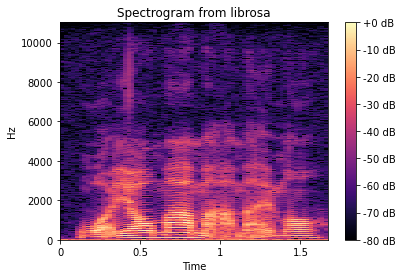

In [26]:
S = librosa.stft(sig)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram from librosa')
fig.colorbar(img, ax=ax, format="%+2.f dB")

What we'll be doing in the problem set is working through the tutorials using the [github code repository code for `python_speech_features.base.mfcc`](https://github.com/jameslyons/python_speech_features/blob/master/docs/source/index.rst). This function calls a ton of other sub-functions we'll need to understand in order to figure out how the computation is proceeding. The basic steps are described in the tutorial [here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/). Let's work through these. But first a quick whirlwind overview to see where we are going.

We can extract MFCC and filter bank features as follows. (Why did I set `nfft = 1024`? What happens if you use defaults?) Note that the extraction we're doing in the next code block is not exactly how you'll be doing it later because you will not be using some of the other defaults.

We can use [numpy's `shape` attribute](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html) to check the size of the resulting matrices computed.

In [27]:
# Extract MFCC features
mfcc_feat = sf.mfcc(sig, fs, nfft = 1024)

# Extract filter bank features
fbank_feat = sf.logfbank(sig, fs, nfft = 1024)

print(fbank_feat.shape)
print(mfcc_feat.shape)

# Print some of fbank features
print(fbank_feat[1:3,:])


(165, 26)
(165, 13)
[[-13.13429909 -15.53799586 -16.6942336  -17.09064434 -16.50508269
  -16.30254061 -15.96329096 -15.88219115 -15.18004284 -15.27872537
  -14.96483402 -14.55067265 -13.98984657 -13.89052743 -13.80984663
  -13.24493184 -12.86779087 -12.43937622 -11.95140259 -11.84679506
  -11.9782192  -11.65998758 -11.35890962 -10.99139886 -10.70348172
  -11.01463967]
 [-13.76627328 -15.49743723 -16.22077911 -17.03225927 -16.74858034
  -16.8761889  -15.97790232 -14.91464301 -15.04848708 -15.41686472
  -14.77593986 -14.62848428 -14.05986675 -14.0866668  -13.52072158
  -13.12826072 -12.95098334 -12.76963268 -12.13779698 -11.88827484
  -11.99552408 -11.44497799 -11.42782347 -11.01295917 -10.83719436
  -10.98968458]]


What do these features look like? Here's an example of how we can visualize them.

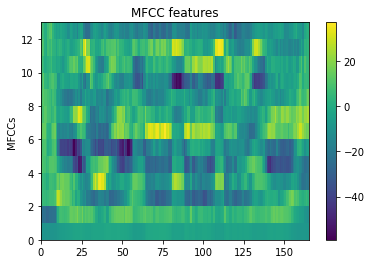

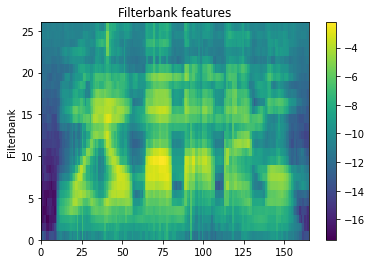

In [28]:
plt.figure()
plt.title("MFCC features")
plt.pcolormesh(np.transpose(mfcc_feat))
plt.ylabel("MFCCs")
plt.colorbar()

plt.figure()
plt.title("Filterbank features")
plt.pcolormesh(np.transpose(fbank_feat))
plt.ylabel("Filterbank")
plt.colorbar()

## Problem 0. Preliminaries

Let's pick some part of the audio file to analyze. We also can normalize the amplitude with respect to the bit depth.

Text(0, 0.5, 'Normalized amplitude')

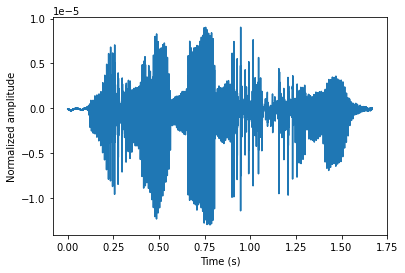

In [29]:
bit_depth = 16
sig_norm = sig/((2**bit_depth)/2) # normalize signal amplitude for 16-bit

plt.figure()
t = np.arange(0, dur_sig, 1/fs) 
plt.plot(t,sig_norm)
plt.xlabel("Time (s)")
plt.ylabel("Normalized amplitude")

We can visually inspect the waveform and see which part of the waveform we want to analyze and then play that extract.

Text(0, 0.5, 'Normalized amplitude')

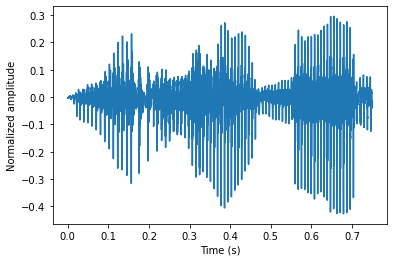

In [30]:
sig_extract = sig[int(0.1 * fs):int(0.85 * fs)]  
sig_extract_norm = sig_extract/((2**bit_depth)/2) # normalize signal amplitude for 16-bit

display(Audio(data=sig_extract, rate=fs))

dur_sig_extract = len(sig_extract) *1/fs 

plt.figure()
t = np.arange(0, dur_sig_extract, 1/fs) 
plt.plot(t,sig_extract)
plt.xlabel("Time (s)")
plt.ylabel("Normalized amplitude")


Ready to tackle the MFCC computation? 

Here's the code from `python_speech_features` for doing so:

```python
def mfcc(signal,samplerate=16000,winlen=0.025,winstep=0.01,numcep=13,nfilt=26,nfft=None,lowfreq=0,highfreq=None,preemph=0.97,ceplifter=22,appendEnergy=True,
         winfunc=lambda x:numpy.ones((x,))):
    """Compute MFCC features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param numcep: the number of cepstrum to return, default 13
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is None, which uses the calculate_nfft function to choose the smallest size that does not drop sample data.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
    :param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    nfft = nfft or calculate_nfft(samplerate, winlen)
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    feat = numpy.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    feat = lifter(feat,ceplifter)
    if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy
    return feat
```

You can see that the first major step is to compute the filter bank via `fbank()`. Then we log-transform the filter bank energies, apply a discrete cosine transform, and lifter.  The bulk of the work happens in the `fbank()` function. The code for that function is:

```python
def fbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
          winfunc=lambda x:numpy.ones((x,))):
    """Compute Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: 2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. The
        second return value is the energy in each frame (total energy, unwindowed)
    """
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = sigproc.powspec(frames,nfft)
    energy = numpy.sum(pspec,1) # this stores the total energy in each frame
    energy = numpy.where(energy == 0,numpy.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    feat = numpy.where(feat == 0,numpy.finfo(float).eps,feat) # if feat is zero, we get problems with log

    return feat,energy
```

We can see that the main steps in `fbank()` are:

1. Pre-emphasis (`signal = sigproc.preemphasis(signal,preemph)`)
2. Frame signal into short frames and window (`frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)`)
3. Compute power spectrum for each frame (`pspec = sigproc.powspec(frames,nfft)`)
4. Compute filter banks (`fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)`)

Let's go!


### Problem 0 Questions [5 pts]

Note: you might skip 0a and 0b for now and come back to it after you've gone through the filterbank and MFCC computations.

- 0a. Explain what is on the x-axis of the MFCC and filterbank plots we did above. Why are there 165 data points along the x-axis?  [2 pts]

- 0b. Explain the difference between the filterbank and MFCC features. To do this, you can check out the github repository code for `python_speech_features`. [2 pts]

- 0c. Pick a speech signal extract from our Beijing Mandarin file to analyze. Explain why you picked that particular extract. [1 pt]

## Problem 1. Pre-emphasis [6 pts]

The first thing we will do is to apply a pre-emphasis filter of the form


$$y_{preemph}(t)=y(t)−\alpha y(t−1)$$

where $\alpha \in [0,1]$. This is called a first-order autoregressive filter because the value at one timepoint of the filtered signal depends on the value at the immediately preceding timepoint, $t-1$, (and only that timepoint and not say, also on the timepoint $t-2$). We can implement this using the code in `python_speech_features.sigproc.preemphasis`, see [github repository code](https://github.com/jameslyons/python_speech_features/blob/master/python_speech_features/sigproc.py), quoted below:

```python
def preemphasis(signal, coeff=0.95):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is no filter, default is 0.95.
    :returns: the filtered signal.
    """
    return numpy.append(signal[0], signal[1:] - coeff * signal[:-1])

```
The purpose of preemphasis is to counteract the natural decay in the strength of harmonics as frequency increases in the voice source spectrum at the glottis, to prevent numerical issues in downstream computations due to smaller numbers for higher frequencies. This harmonic amplitude envelope trend is referred to as the spectral slope. See for instance the image below from [a Macquarie University phonetics page](https://www.mq.edu.au/about/about-the-university/our-faculties/medicine-and-health-sciences/departments-and-centres/department-of-linguistics/our-research/phonetics-and-phonology/speech/acoustics/acoustic-theory-of-speech-production/sound-sources-in-the-vocal-tract)1

![Voice source slope](https://www.mq.edu.au/__data/assets/image/0007/911185/source_220_74_100.gif)

If you take a look at that page, you can also play samples of different spectral slopes/rolloff and understand a bit better, why the envelope for harmonic amplitudes at the voice source looks that way. The standardly assumed -12dB/octave drop off is based on mathematical models of glottal pulse (that idealized them as triangular!) from [Carr, P. B., & Trill, D. (1964). Long-term larynx-excitation spectra. The Journal of the Acoustical Society of America, 36, 2033–2040](https://asa.scitation.org/doi/10.1121/1.1919319)


***(1a) Use the code snippet from the quoted function above to apply a pre-emphasis filter to your speech signal extract. You can use the default setting for the pre-emphasis filter. [2 pts]*** 

***(1b) Plot the pre-emphasized output and your original signal extract in the time domain on the same plot and describe the difference between your original signal and your pre-emphasized one. [2 pts]***

***(1c) Plot the spectrograms of your pre-emphasized output and your original signal extract on the same plot and describe the difference between the spectra of your original signal and your pre-emphasized one. [2 pts]***


## Problem 2: Frame the signal into short frames and window. [6 pts]

For this step, we'll need to understand `python_speech_features.sigproc.framesig`. You can find the code for that function at the [github repository](https://github.com/jameslyons/python_speech_features/blob/master/python_speech_features/sigproc.py). You've already done this kind of thing before a few times, so let's just go ahead and use Lyon's function.

```python
def framesig(sig, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,)), stride_trick=True):
    """Frame a signal into overlapping frames.
    :param sig: the audio signal to frame.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :param stride_trick: use stride trick to compute the rolling window and window multiplication faster
    :returns: an array of frames. Size is NUMFRAMES by frame_len.
    """
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step))

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = numpy.zeros((padlen - slen,))
    padsignal = numpy.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
            numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = numpy.array(indices, dtype=numpy.int32)
        frames = padsignal[indices]
        win = numpy.tile(winfunc(frame_len), (numframes, 1))

    return frames * win
```

***(2a) Use `python_speech_features.sigproc.framesig` with a frame size of 25ms and a frame shift of 10 ms and a Hamming window to generate frames. [2pts]*** 

***(2b) How many samples are in each frame? Explain why there are that many samples.[2pts]***

***(2c) Use `help(np.hamming)` to find the equation for a Hamming window. Plot a Hamming window. Plot (in the time domain) one of your frames windowed with a rect window and also windowed with a Hamming window and compare the plots from the two window choices.[2pts]*** 


`help(np.hamming)` tells us that the equation for a Hamming window is:
$$w(n) = 0.54 - 0.46cos\left(\frac{2\pi{n}}{M-1}\right)
               \qquad 0 \leq n \leq M-1$$
               
It also conveniently gives us code to plot the Hamming window:              

## Problem 3. For each frame calculate the power spectrum. [3 pts]

For this step, we'll need to understand `python_speech_features.sigproc.powspec` and `python_speech_features.sigproc.magspec`. Inspect the code of the functions at the github repository, as well as `python_speech_features.calculate_nfft`, also shown below. Note that the power spectrum computation includes a normalization by the number of FFT points (or bins). See [this stack exchange answer](https://dsp.stackexchange.com/questions/66058/am-i-supposed-to-normalize-fft-in-python) for some more on why that normalization is done.

```python
def powspec(frames, NFFT):
    """Compute the power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).
    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the power spectrum of the corresponding frame.
    """
    return 1.0 / NFFT * numpy.square(magspec(frames, NFFT))
```

```python
def magspec(frames, NFFT):
    """Compute the magnitude spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).
    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the magnitude spectrum of the corresponding frame.
    """
    if numpy.shape(frames)[1] > NFFT:
        logging.warn(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            numpy.shape(frames)[1], NFFT)
    complex_spec = numpy.fft.rfft(frames, NFFT)
    return numpy.absolute(complex_spec)
```

```python
def calculate_nfft(samplerate, winlen):
    """Calculates the FFT size as a power of two greater than or equal to
    the number of samples in a single window length.
    
    Having an FFT less than the window length loses precision by dropping
    many of the samples; a longer FFT than the window allows zero-padding
    of the FFT buffer which is neutral in terms of frequency domain conversion.
    :param samplerate: The sample rate of the signal we are working with, in Hz.
    :param winlen: The length of the analysis window in seconds.
    """
    window_length_samples = winlen * samplerate
    nfft = 1
    while nfft < window_length_samples:
        nfft *= 2
    return nfft
```

***(3a) Use the `calculate_nfft` function to compute an appropriate number for the FFT size and explain why the number is a power of 2. (1 pt)***

***(3b) Compute the power spectrum for each frame using `python_speech_features.sigproc.powspec,` using the FFT size you just computed (1 pt)***

***(3c) Plot the power spectrogram on the decibel scale, following [the same formula as Praat](https://www.fon.hum.uva.nl/praat/manual/power_spectral_density.html), shown below. It should look something like the librosa spectrogram we plotted earlier (1 pt)***

$$ PSD_{dB}(f) = 10 \log_{10} \frac{PSD(f)}{P_{ref}^2}$$

where $P_{ref} = 2 \times 10^{-5} Pa$, a standard reference used as the threshold for audible sound


### Problem 4. Compute the filter bank. (5 pts)

For this step, we'll need to understand `python_speech_features.base.get_filterbanks` and the mel scale.

#### The mel scale
The mel scale was empirically determined by asking listeners to judge when they perceived a pure tone as having half the pitch of a reference tone, starting at 1000 Hz, with 1000 mels defined to be 1000 Hz as a first reference.

There are various formulas people have used to do conversion between mel and Hz and other perceptual units used for frequency. Some are given at [this webpage from Traunmüller](https://www2.ling.su.se/staff/hartmut/bark.htm#conv). See also [an Auditory.org e-mail thread discussion of the history of mel scale conversions](http://www.auditory.org/postings/2009/581.html). 

#### Mel filter banks

The Mel filter bank is a set of overlapping triangular windows in the frequency domain whose centers and bandwidths are motivated by critical bands. Each filter has a response of 1 at the center frequency and then a response of 0 at the center frequency of its neighboring filters; then linear interpolation between 1 and 0 is used to get the "triangular" shape.   The `get_filterbanks` code from the `python_speech_features` github repository is given below:

```python
def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = numpy.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = numpy.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = numpy.zeros([nfilt,nfft//2+1])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank
```

***(4a) Which formula is used in the `python_speech_features` code (check the github repository)? Is it the same as Traunmüller's listed formula, given below? (1 pt)***

$$mel(\text{f0}_{Hz}) = 1127 \ln\left(1 + \frac{\text{f0}_{Hz}}{700}\right)$$


***(4b) Use `get_filterbanks()` to generate the mel-scaled filter bank. Use the default number of filters, 20 and other defaults, but make sure to use the FFT size you computed earlier and the sampling rate of the audio file. (1 pt)***

***(4c) Plot the full filterbank. Hint: see http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/ for some examples. In addition, isolate out one of the filters centered at a lower frequency, .e.g, around 1000 Hz, and one of the higher ones, e.g., at 5000 Hz and plot those isolated filters, too. Compare their bandwidths. Explain how the filter bandwidths reflect the idea of critical bands. Note: you can suppress unwanted text output from plotting by ending your plot command with a semi-colon. (4 pt)***


## Problem 5. Apply the mel filterbank to the power spectra and take the logarithm of all filterbank energies (6 pts)

For this step, we'll need to understand `python_speech_features.base.fbank` Let's also consider why we do a log transform. One auditorily-motivated reason is due to the power law relation between intensity (acoustic measure) and loudness (perceptual measure). Another reason is to decrease sensitivity to small variations in the input signal. And a mathematical reason is that then we get addition of our envelope ("filter") and harmonic ("source") components, rather than multiplication.

The relevant code from `python_speech_features.base.fbank` is excerpted below. (Note: the function also computes the total energy in each frame for a variant of MFCCs where the zeroth cepstral coefficient is replaced with the log of the total frame energy, but we won't worry about that here.)

After this step is where we stop if we are using filter bank energies as features. But if we are using MFCCs we keep on going.

```python
feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
feat = numpy.where(feat == 0,numpy.finfo(float).eps,feat) # if feat is zero, we get problems with log

```
For the log transform of the filterbank energies, all you need is `numpy.log()`.

***(5a) Compute the log-transformed filterbank energies using the code snippet above and adding a line to do the log transform. (2 pt)***

***(5b) Explain what the line `feat = np.dot(pspec,fb.T)` does. (2 pts)***

***(5c) Plot the log-transformed filterbank energies. (2pts)***

### Problem 6. Apply DCT to log filterbank energies; keep first 13 DCT coefficients and discard the rest. (4pt)

You can think of applying the Discrete Cosine Transform (DCT) as a variation of the step of applying the inverse Fourier Transform that we discussed in our first definition of the cepstrum. A basic intuition of what's going on here is that we are working with real signals, and the DCT gives us a basis for just the real parts of a function, recalling that our original Fourier Transform uses a complex exponential basis, including a real-valued cosine component and an imaginary-valued sine component.  See also [this discussion of DCT](https://dsp.stackexchange.com/a/15945)

The relevant lines from `python_speech_features.base.mfcc` are shown below.

```python
from scipy.fftpack import dct
numcep=13 # default number of cepstral coefficents
feat = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
```    

You can find out more info about `scipy.sig.fftpack.dct` via its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html).

***(6a) Apply DCT to log filterbank energies; keep first 13 DCT coefficients and discard the rest. [1 pt]***

***(6b) Plot the first six DCT basis functions, i.e., for $k\in[0,5]$. Check `scipy.sig.fftpack.dct` for the DCT type 2 formula to get the formula that generates the basis functions. Let $N=20$ in the formula. The part you want is everything except $x_n$. Comment on the shape of the basis functions. (3 pts)***

### Problem 7: Lifter. (3pts)

The relevant line from `python_speech_features.base.mfcc` is shown below.

```python
ceplifter=22 # default number 
feat = lifter(feat,ceplifter)
```    

For this step, we'll need to understand `python_speech_features.base.lifter`, which is given below. Note that the [default of 22 comes from HTK](https://dsp.stackexchange.com/a/73188), which was the implementation of HMMs that was standardly used over last couple decades before neural nets caught on.

The particular "lifter" (i.e., filter, in the cepstral domain) used in the code below is a sinusoidal lifter that emphasizes middle cepstral coefficients by giving lower weight to both higher and lower cepstral coefficients. That is, it is a [bandpass](https://maxwell.ict.griffith.edu.au/spl/publications/papers/euro99_kkp_fbe.pdf) [filter](https://dsp.stackexchange.com/a/26054) in the spectral domain, which helps emphasize the spectral envelope shape and [de-emphasize high quefrency terms (which have large variances and diminishing contributions to discrimination between spectra) and low quefrency terms (which are primarily influenced by transmission channel and speaker-specific characteristics.](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/260_bandpass%20liftering.pdf)

```python
def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs. (KY I'm not so sure about this)
    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes,ncoeff = numpy.shape(cepstra)
        n = numpy.arange(ncoeff)
        lift = 1 + (L/2.)*numpy.sin(numpy.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra
```    

***(7a) Lifter your filterbank energies using `sf.lifter` [1 pt]***

***(7b) Plot the original filterbank energies and compare to plot of the liftered filterbank energies. Describe the change after liftering. [2 pts]***